# Flow Cytometry analysis coinfection

Analysis of flow cytometry data in support of chromium pipeline. Single cells already gated using FlowJo, everything else to be done algorithmically

Initialize libraries

In [2]:
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import scipy.io
import pandas as pd
import seaborn as sns
import importlib
from scipy import stats
import statsmodels


import statsmodels
#set directory filepaths
workingDirectory = os.getcwd() + '/'


Initialize dataset and labels

In [3]:
flowDirectory = 'Flow_Cytometry/'
datafile = flowDirectory + 'coinfection.tsv' 
flowdataframe = pd.read_table(datafile)
fluorlabels = ['eGFP', 'WT']
samples = ['Coinf_1', 'Coinf_2', 'Coinf_3', 'eGFP', 'PB1', 'Uninfected', 'WT']
flowdataframe = flowdataframe.rename(columns={'FITC.A': 'eGFP', 'APC.A': 'WT'})


Define gates for single positive and double-positive cells. Define on single-stain controls, but confirm numbers are consistent with double-negative sample

In [4]:
singlesamples = ['eGFP', 'WT']
negsamp = ['Uninfected']
percentile = 0.9995
cutoffs = {}
for sample in singlesamples:
    sub = flowdataframe[flowdataframe.file == sample]
    for item in fluorlabels:
        print('For singly infected cells of ' + sample + " " + str(percentile * 100) + ' percent of the cells have less than ' +
                 str(sub[item].quantile(percentile)) + ' of ' + item + ' signal')
        if item != sample:
            cutoffs[item] = sub[item].quantile(percentile)

for sample in negsamp:
    sub = flowdataframe[flowdataframe.file == sample]
    for item in fluorlabels:
        print('For ' + sample + " " + str(percentile * 100) + ' percent of the cells have less than ' +
                 str(sub[item].quantile(percentile)) + ' of ' + item + ' signal')

For singly infected cells of eGFP 99.95 percent of the cells have less than 121597.64722658276 of eGFP signal
For singly infected cells of eGFP 99.95 percent of the cells have less than 143.639999389648 of WT signal
For singly infected cells of WT 99.95 percent of the cells have less than 340.800018310547 of eGFP signal
For singly infected cells of WT 99.95 percent of the cells have less than 96773.74365234375 of WT signal
For Uninfected 99.95 percent of the cells have less than 337.20001220703097 of eGFP signal
For Uninfected 99.95 percent of the cells have less than 144.77999877929702 of WT signal


Report infection status, save reduced table with only flu+ cells

In [12]:

for sample in samples:
    sub = flowdataframe[flowdataframe.file==sample]
    total = len(sub)
    GFPpos = len(sub[(sub['eGFP'] > cutoffs['eGFP']) & (sub['WT'] <= cutoffs['WT'])])
    HApos = len(sub[(sub['WT'] > cutoffs['WT']) & (sub['eGFP'] <= cutoffs['eGFP'])])
    doublepos = len(sub[((sub['eGFP'] > cutoffs['eGFP']) &
                                                          (sub['WT'] > cutoffs['WT']))])
    print("For sample {0}, with {1} cells, {2} percent are GFP positive, {3} percent are HA positive, {4} percent are positive for both, and {5} percent are negative for both.".
         format(sample, total, round(100*float(GFPpos)/total,4),round(100* float(HApos)/total,10), round(100*float(doublepos)/total,4), round(100 - 100*float(doublepos + HApos + GFPpos)/total, 4)))


For sample Coinf_1, with 974956 cells, 3.3525 percent are GFP positive, 10.0495817247 percent are HA positive, 1.0156 percent are positive for both, and 85.5823 percent are negative for both.
For sample Coinf_2, with 975057 cells, 3.797 percent are GFP positive, 8.7279000099 percent are HA positive, 0.9815 percent are positive for both, and 86.4936 percent are negative for both.
For sample Coinf_3, with 978755 cells, 4.0007 percent are GFP positive, 7.4024653769 percent are HA positive, 0.8555 percent are positive for both, and 87.7414 percent are negative for both.
For sample eGFP, with 488131 cells, 4.3062 percent are GFP positive, 0.0393337035 percent are HA positive, 0.0104 percent are positive for both, and 95.644 percent are negative for both.
For sample PB1, with 486883 cells, 0.0581 percent are GFP positive, 0.1714991076 percent are HA positive, 0.0173 percent are positive for both, and 99.7531 percent are negative for both.
For sample Uninfected, with 245266 cells, 0.0371 perc

Report graphs from flowjo using above values

Kernel density plots for single color, single color in coinfection, and dual-color in coinfection

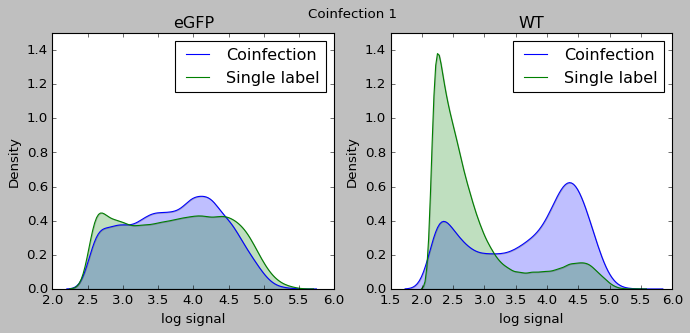

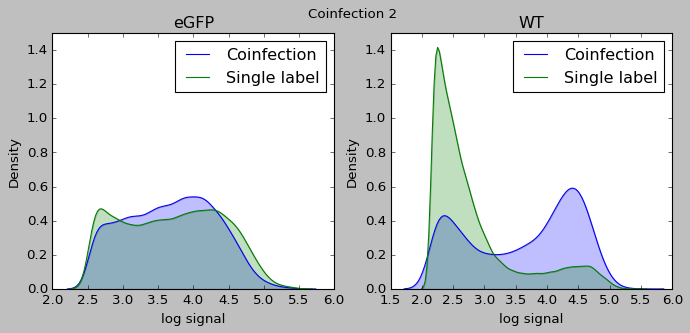

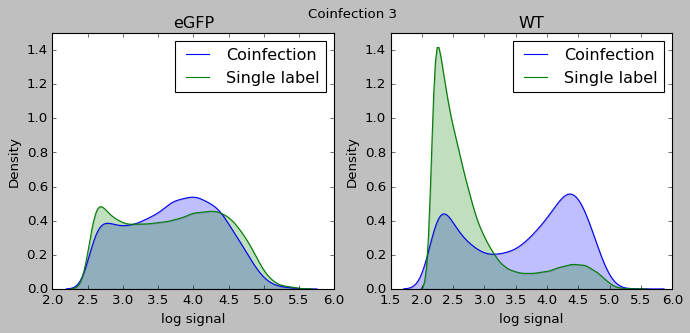

In [7]:
y = 1
coinfected = ['Coinf_1', 'Coinf_2', 'Coinf_3']
labels = {'Coinf_1':'Coinfection 1','Coinf_2': 'Coinfection 2', 'Coinf_3':'Coinfection 3'}
for sample in coinfected:
    plt.figure(y, (10,4))
    y += 1
    plt.suptitle(labels[sample])
    x = 121
    sub = flowdataframe[flowdataframe.file==sample]
    for label1 in fluorlabels:
        for label2 in fluorlabels:
            if label1 != label2:
                plt.subplot(x)
                singleInfect = sub[(sub[label1] > cutoffs[label1]) & (sub[label2] <= cutoffs[label2])][label1]
                doubleInfect = sub[(sub[label1] > cutoffs[label1]) & (sub[label2] > cutoffs[label2])][label1]
                #log transform for easier plotting and handling of bins - desire wider bins at higher values
                singleInfect = np.log10(singleInfect)
                doubleInfect = np.log10(doubleInfect)
                x += 1
                sns.kdeplot(data = doubleInfect, shade = True, label='Coinfection')
                sns.kdeplot(data = singleInfect, shade = True, label='Single label')
                #sns.distplot(singleInfect, norm_hist = True, label = 'Single color', kde=False)
                #sns.distplot(doubleInfect, norm_hist = True, label = 'Coinfection', kde=False)
                plt.title(label1)
                plt.xlabel(label1)
                plt.legend()
                plt.ylabel('Density')
                plt.ylim(0, 1.5)
                plt.xlabel('log signal')
                plt.savefig(workingDirectory + labels[sample] + '_distribution.pdf', format='pdf' )


Quantile looking at signal correlation

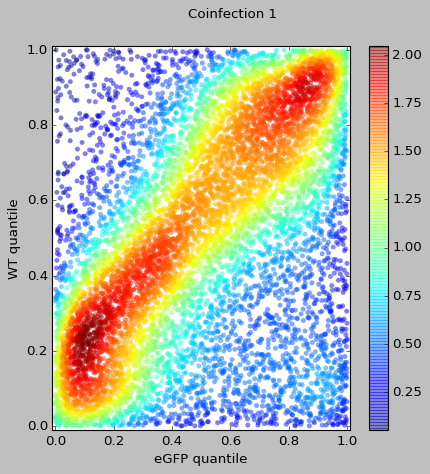

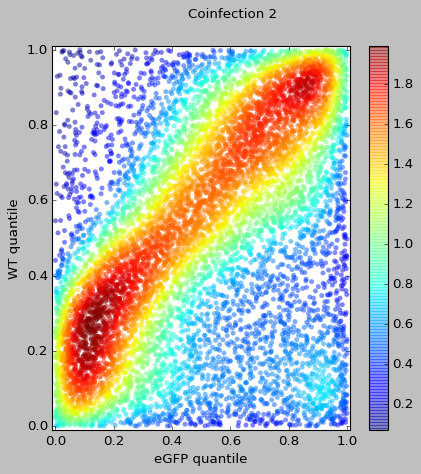

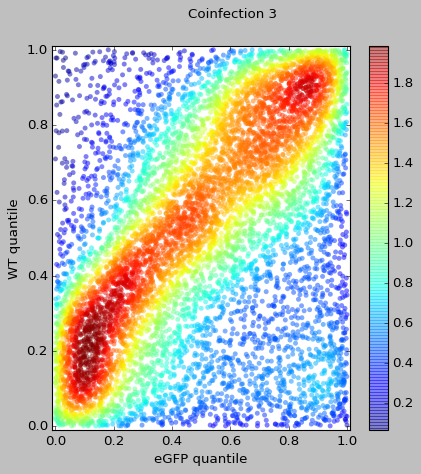

In [8]:
coinfection = ['Coinf_1', 'Coinf_2', 'Coinf_3']
labels = {'Coinf_1':'Coinfection 1','Coinf_2': 'Coinfection 2', 'Coinf_3':'Coinfection 3'}
mpl.style.use('classic')
y = 1
label1 = 'eGFP'
label2 = 'WT'
for sample in coinfection:
    x = 121
    sub = flowdataframe[flowdataframe.file == sample]
    #Set all coinfections to quantiles
    sub = sub[(sub[label1] > cutoffs[label1]) & (sub[label2] > cutoffs[label2])]
    
    sub[label1] = sub.apply(lambda row: 
                        stats.percentileofscore(sub[label1], row[label1])/100
                        if (row[label1] > cutoffs[label1])
                        else 0, axis = 1)
    sub[label2] = sub.apply(lambda row: 
                        stats.percentileofscore(sub[label2], row[label2])/100
                        if (row[label2] > cutoffs[label2])
                        else 0, axis = 1)
    kde = scipy.stats.gaussian_kde(sub.as_matrix(columns=[label1, label2]).T)
    gausscolors = kde(sub.as_matrix(columns=[label1, label2]).T)

    #take upper and lower
    plt.figure(y, (6,6))
    plt.suptitle(labels[sample])
    y += 1
    #sns.regplot(data = sub, x = label1, y = label2, color =gausscolors, fit_reg=False)
    plt.scatter(sub[label1], sub[label2], c=gausscolors, alpha=0.5, edgecolors='none', cmap='jet')
    plt.colorbar()
    plt.xlabel(label1 + ' quantile')
    plt.ylabel(label2 + ' quantile')
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01,1.01)
    plt.savefig(workingDirectory + labels[sample] + '_quantileCOinf.pdf', format='pdf' )





Linear regression statistics for above

In [6]:

coinfection = ['Coinf_1', 'Coinf_2', 'Coinf_3']
label1 = 'eGFP'
label2 = 'WT'
for sample in coinfection:
    x = 121
    sub = flowdataframe[flowdataframe.file == sample]
    #Set all coinfections to quantiles
    sub = sub[(sub[label1] > cutoffs[label1]) & (sub[label2] > cutoffs[label2])]
    
    sub[label1] = sub.apply(lambda row: 
                        stats.percentileofscore(sub[label1], row[label1])/100
                        if (row[label1] > cutoffs[label1])
                        else 0, axis = 1)
    sub[label2] = sub.apply(lambda row: 
                        stats.percentileofscore(sub[label2], row[label2])/100
                        if (row[label2] > cutoffs[label2])
                        else 0, axis = 1)
    
    print(stats.linregress(sub[label1],sub[label2]))


LinregressResult(slope=0.46396090143127833, intercept=0.26804661649798278, rvalue=0.46396098226450194, pvalue=0.0, stderr=0.008903182574167702)
LinregressResult(slope=0.42747151062255712, intercept=0.28629415735796793, rvalue=0.42747160344271001, pvalue=0.0, stderr=0.0092421194473039422)
LinregressResult(slope=0.43934066912840763, intercept=0.28036314562992443, rvalue=0.43934077660771764, pvalue=0.0, stderr=0.0098184407327472269)


Bargraph of deviation